<a href="https://colab.research.google.com/github/nhatminh-it/fruits_classification/blob/master/Final_model_FruitClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import thư viện cần thiết**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle

Khởi tạo label

In [ ]:
labels = ['cachua', 'cam', 'chuoi', 'duahau', 'le', 'nho', 'quyt', 'tao', 'thom', 'xoai']

**Khởi tạo model RandomForestClassifier**

In [ ]:
rfc = RandomForestClassifier(random_state=42)

**Thiết lập phạm vi parameters của RandomForestClassifier cho GridSearchCV**

In [ ]:
rfc_params = {'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400],
              'max_depth' : [5, 7, 9, 11, 13, 15, 17, 19]}

**Khởi tạo model SVC**

In [ ]:
svc = SVC(random_state=42)

**Thiết lập phạm vi parameters của SVC cho GridSearchCV**

In [ ]:
svc_params = {'kernel' : ['rbf', 'poly', 'linear'],
              'degree' : [3, 5]}

Hàm phát họa 1 confusion matrix dựa trên 1 confusion matrix đã có và lưu về drive

Function INPUT: confusion_matrix cần phát họa, label, title cho plot, tên export về drive

Function OUTPUT: 1 ảnh confusion matrix, ảnh đó về drive theo path có sẵn



In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix',export_as='confusion_matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    plt.savefig(f'/content/drive/My Drive/Fruit recognition/plots image/{export_as}.png', bbox_inches='tight');

**Load dataframe đã lưu ở nhưng notebook trước**

* edge_cluster: 
  * dataframe được tạo bởi thuật toán tìm cạnh Canny Edge trên ảnh đã được phần cụm còn 2 màu dùng thuật toán Kmeans. 
  * Sau đó tính mean và std của từng phần 40x40 pixels
  * dataframe gồm 51 cột, 1 cột label, 50 cột features

* cluster_features_2: 
  * được tạo bởi ảnh đã được phần cụm còn 2 màu dùng thuật toán Kmeans. 
  * Sau đó tính mean và std của từng Channel màu.
  * dataframe gồm 7 cột, 1 cột label, 6 cột features

In [ ]:
edge_cluster_train = pd.read_csv('/content/drive/My Drive/Fruit recognition/output_input/25_edge+cluster_train_features.csv')
edge_cluster_test = pd.read_csv('/content/drive/My Drive/Fruit recognition/output_input/25_edge+cluster_valid_features.csv')

cluster_features_2_train = pd.read_csv('/content/drive/My Drive/Fruit recognition/output_input/25_cluster_features_2_train.csv')
cluster_features_2_test = pd.read_csv('/content/drive/My Drive/Fruit recognition/output_input/25_cluster_features_2_test.csv')

In [ ]:
print(edge_cluster_train.shape)
print(edge_cluster_test.shape)
print(cluster_features_2_train.shape)
print(cluster_features_2_test.shape)

(1870, 51)
(630, 51)
(1870, 7)
(630, 7)


Ghép 2 dataframe lại

In [ ]:
df_train = pd.concat([cluster_features_2_train, edge_cluster_train.drop(['name'], axis=1)],axis=1)
df_test = pd.concat([cluster_features_2_test, edge_cluster_test.drop(['name'], axis=1)],axis=1)

In [ ]:
print(df_train.shape)
print(df_test.shape)

(1870, 57)
(630, 57)


In [ ]:
Y_train = df_train['name']
X_train = df_train.drop(['name'], axis=1)
Y_test = df_test['name']
X_test = df_test.drop(['name'], axis=1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1870, 56)
(630, 56)
(1870,)
(630,)


Sử dụng GridSearchCv train model RandomForestClassifier

In [ ]:
rfc_final = GridSearchCV(rfc, param_grid=rfc_params, n_jobs=-1)
rfc_final.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                               

In [ ]:
print('best param:', rfc_final.best_params_)
print('train_acc:',accuracy_score(Y_train, rfc_final.predict(X_train)))
rfc_test_acc = accuracy_score(Y_test, rfc_final.predict(X_test))
print('test acc:', rfc_test_acc)

best param: {'max_depth': 15, 'n_estimators': 300}
train_acc: 1.0
test acc: 0.9523809523809523


Lấy confusion matrix

In [ ]:
rfc_pred = rfc_final.predict(X_test)
conf_mat_rfc = confusion_matrix(Y_test, rfc_pred)
conf_mat_rfc

array([[63,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 63,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 62,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0, 61,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0, 48,  1,  0,  7,  2,  5],
       [ 0,  0,  0,  0,  0, 63,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 62,  0,  0,  0],
       [ 6,  0,  0,  0,  0,  2,  0, 55,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 63,  0],
       [ 0,  0,  2,  0,  1,  0,  0,  0,  0, 60]])

Normalized confusion matrix


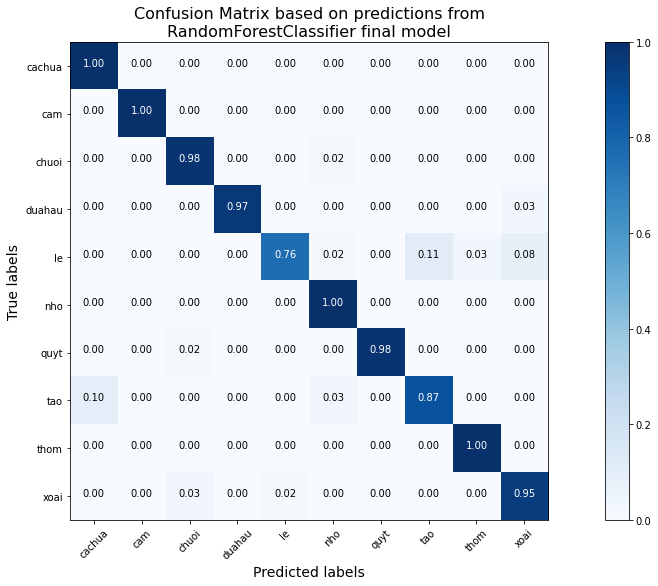

In [ ]:
cm_plot_labels = labels

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_rfc, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from\nRandomForestClassifier final model",
                      export_as="rfc_final_model"
                     )

plt.show()

Sử dụng GridSearchCV train model SVC

In [ ]:
svc_final = GridSearchCV(svc, param_grid=svc_params, n_jobs=-1)
svc_final.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'degree': [3, 5], 'kernel': ['rbf', 'poly', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print('best params:',svc_final.best_params_)
print('train_acc:',accuracy_score(Y_train, svc_final.predict(X_train)))
svc_test_acc = accuracy_score(Y_test, svc_final.predict(X_test))
print('test_acc:',svc_test_acc)

best params: {'degree': 3, 'kernel': 'linear'}
train_acc: 1.0
test_acc: 0.9412698412698413


Lấy confusion matrix

In [ ]:
svc_pred = svc_final.predict(X_test)
conf_mat_svc = confusion_matrix(Y_test, svc_pred)
conf_mat_svc

array([[60,  0,  0,  0,  0,  2,  0,  1,  0,  0],
       [ 0, 60,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 61,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 63,  0,  0,  0,  0,  0,  0],
       [ 3,  1,  1,  0, 53,  1,  0,  2,  0,  2],
       [ 0,  0,  0,  0,  0, 62,  0,  1,  0,  0],
       [ 0,  0,  2,  0,  0,  0, 60,  0,  0,  1],
       [ 6,  0,  0,  0,  0,  0,  0, 57,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0, 62,  0],
       [ 0,  0,  0,  2,  5,  0,  1,  0,  0, 55]])

Normalized confusion matrix


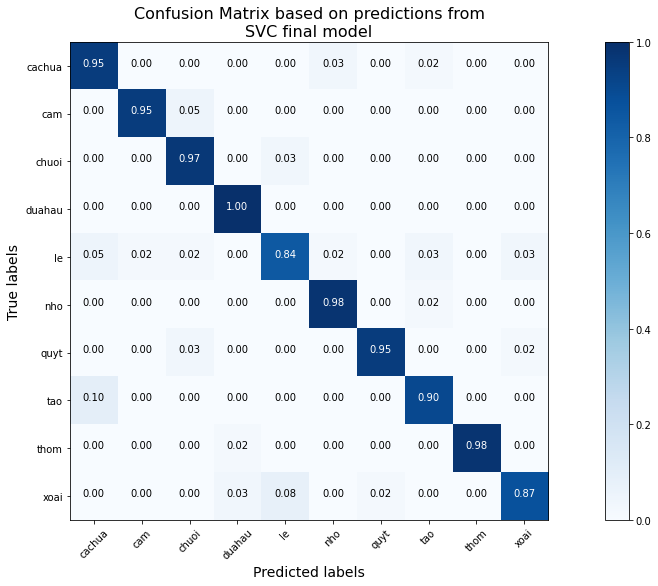

In [ ]:
cm_plot_labels = labels

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_svc, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from\nSVC final model",
                      export_as="svc_final_model"
                     )

plt.show()

Lưu 2 model về drive

In [ ]:
rfc_pickle = f"/content/drive/My Drive/Fruit recognition/models/rfc_final_model_acc_{round(rfc_test_acc, 3)}"
pickle.dump(rfc_final, open(rfc_pickle, 'wb'))

svc_pickle = f"/content/drive/My Drive/Fruit recognition/models/svc_final_model_acc_{round(svc_test_acc, 3)}"
pickle.dump(svc_final, open(svc_pickle, 'wb'))

# Tổng kết
* RandomForestClassifier

 * best param: {'max_depth': 15, 'n_estimators': 300}
 * train accuracy: 1.0
 * test accuracy: 0.9523809523809523
 * Những trái đúng 100% trong tập test: cà chua, cam, nho, thơm

* SVC
 * best params: {'degree': 3, 'kernel': 'linear'}
 * train accuracy: 1.0
 * test accuracy: 0.9412698412698413
 * Những trái đúng 100% trong tập test: dưa hấu